In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Environment import MDP 
import utils as u

sns.set_theme(font_scale = 0.7)
sns.set_style()

In [60]:
def bellman_expectation(env, pi):
    p_pi = np.zeros((env.nstates, env.nstates))
    r_pi = np.zeros((env.nstates))
    for s in range(env.nstates):
        for a in range(env.agent.n_actions):
            p_pi[s] += env.dynamics_environment(state = s, action = a)[3] * pi[s][a] 
            r_pi[s] += env.R[a][s] * pi[s][a]
    return np.linalg.inv((np.identity(env.nstates) - (env.gamma * p_pi))) @ r_pi.T

def random_deterministic_policy(env):
    pi = np.zeros((env.nstates, env.agent.n_actions))
    indexes = np.random.choice(env.agent.n_actions, env.nstates)
    pi[np.arange(env.nstates), indexes] = 1
    return pi

In [61]:
env = MDP(width = 5, height = 5, gamma = 0.9)
goal_state = 4
env.set_rewards(goal_state)

In [62]:
#solution
bellman_expectation(env, env.agent.policy)

array([0.1582304 , 0.25290899, 0.51202224, 1.14612661, 2.75592177,
       0.13387643, 0.20087831, 0.36459656, 0.67982543, 1.14612661,
       0.10202122, 0.14141053, 0.22770319, 0.36459656, 0.51202224,
       0.07611947, 0.0978885 , 0.14141053, 0.20087831, 0.25290899,
       0.06227957, 0.07611947, 0.10202122, 0.13387643, 0.1582304 ])

### Iterative Policy Evaluation

steps: 7


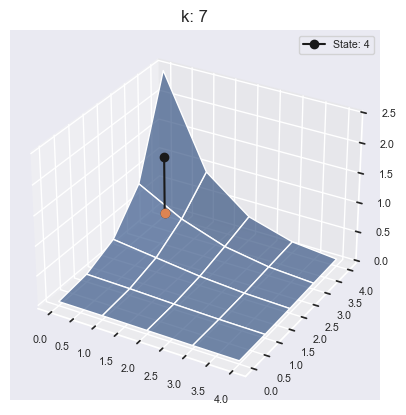

In [63]:
#algorithm 4.1: Iterative policy evaluation
v_0 = 0
theta = 0.1
pi = env.agent.policy
env = env

v_next = np.zeros(env.nstates) + v_0
delta = np.ones(env.nstates)
terminate = False
k = 1
fig = env.render(goal_state, env.fit_grid(v_next), f'k: {k}')
plt.close(fig)
while terminate is False:
    v_old = np.copy(v_next)
    for s in range(env.nstates):
        v_next[s] = 0 # reset value
        # sum over actions
        for a in range(env.agent.n_actions):
            
            # sum over successor values
            v_next[s] += pi[s][a] * ((env.R[a][s] + np.dot(env.P[a][s], env.gamma * v_old))) 
        delta[s] = abs(v_old[s] - v_next[s])    
        fig = env.render(goal_state, env.fit_grid(v_next), f'k: {k}')
        plt.close(fig)

        # in place: 
        v_old[s] = v_next[s]
    #Termination conditions
    if np.all(delta < theta) or (k == 1000): 
        terminate = True
        fig = env.render(goal_state, env.fit_grid(v_next), f'k: {k}')
        print(f'steps: {k}')
    k+=1


In [65]:
# Rendering makes it very slow, however, clear what happens
env.fit_grid(v_next)

array([[0.01907658, 0.08300465, 0.29499917, 0.88803863, 2.47656273],
       [0.01831717, 0.06642101, 0.2004237 , 0.48980805, 0.94269959],
       [0.012608  , 0.04059234, 0.10845722, 0.22915462, 0.36808129],
       [0.00719192, 0.02150292, 0.05285215, 0.10145121, 0.14767992],
       [0.00402985, 0.01188671, 0.02813296, 0.05127799, 0.07092249]])

In [66]:
# Get optimal policy
s = 0
optimal_actions = []
for s in range(env.nstates):
    best_value = 0
    for a in range(env.agent.n_actions):
        
        value_action = max(env.P[a][s] * v_next)
        if value_action >= best_value:
            best_action = env.agent.actions.get(a)[1]
            best_value = value_action
    optimal_actions.append(best_action)
print(env.fit_grid(optimal_actions))
        

[['→' '→' '→' '→' '→']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '↑' '↑']
 ['→' '→' '↑' '↑' '↑']
 ['→' '→' '↑' '↑' '↑']]


In [67]:
def policy_evaluation(env, pi, theta, V_0):
    v_next = np.zeros(env.nstates) + V_0
    delta = np.ones(env.nstates)
    terminate = False
    k = 1
    
    while terminate is False:
        v_old = np.copy(v_next)

        for s in range(env.nstates):
            v_next[s] = 0 # reset value

            # sum over actions
            for a in range(env.agent.n_actions):
            
                # sum over successor values
                v_next[s] += pi[s][a] * ((env.R[a][s] + np.dot(env.P[a][s], env.gamma * v_old))) 

            delta[s] = abs(v_old[s] - v_next[s])    

            # in place: 
            v_old[s] = v_next[s]

        #Termination conditions
        if np.all(delta < theta) or (k == 1000): 
            terminate = True
            
        k+=1
    return v_next

In [68]:
policy_evaluation(env = env, pi = env.agent.policy, theta = 0.1, V_0 = 0)

array([0.01907658, 0.08300465, 0.29499917, 0.88803863, 2.47656273,
       0.01831717, 0.06642101, 0.2004237 , 0.48980805, 0.94269959,
       0.012608  , 0.04059234, 0.10845722, 0.22915462, 0.36808129,
       0.00719192, 0.02150292, 0.05285215, 0.10145121, 0.14767992,
       0.00402985, 0.01188671, 0.02813296, 0.05127799, 0.07092249])

### Policy Improvement

In [69]:
# create random deterministic policy
pi = np.zeros((env.nstates, env.agent.n_actions))
indexes = np.random.choice(env.agent.n_actions, env.nstates)
pi[np.arange(env.nstates), indexes] = 1
print('Random deterministic policy:')
u.policy_visual(env, pi)
random_policy = pi

Random deterministic policy:
[['←' '↓' '→' '→' '←']
 ['↑' '↑' '←' '→' '←']
 ['→' '↑' '←' '←' '↓']
 ['↓' '←' '←' '→' '→']
 ['↑' '→' '←' '←' '↑']]


In [70]:
# Evaluate
v_pi = policy_evaluation(env, random_policy, 0.01, 0)

In [72]:
a, s = 0, 13
v_old = v_pi[s]
pi_new = random_policy
q_value = env.R[a][s] + np.sum(env.P[a][s] * env.gamma * (v_pi))
print(q_value)
if q_value > v_old:
    pi_new[s] = a
u.policy_visual(env, pi_new)

0.0
[['←' '↓' '→' '→' '←']
 ['↑' '↑' '←' '→' '←']
 ['→' '↑' '←' '←' '↓']
 ['↓' '←' '←' '→' '→']
 ['↑' '→' '←' '←' '↑']]


In [73]:
# greedy policy, one sweep
pi_new = random_policy
q_values = np.zeros((env.nstates, env.agent.n_actions))

for s in range(env.nstates):
    for a in range(env.agent.n_actions):
        q_values[s][a] = env.R[a][s] + np.sum(env.P[a][s] * env.gamma * (v_pi))
    best_action = np.argmax(q_values[s])
    pi_new[s] = u.one_hot(best_action, env.agent.n_actions)
u.policy_visual(env, pi_new)

[['↑' '→' '→' '→' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']]


In [74]:
def policy_improvement(env, v_pi):
    pi_next = np.zeros((env.nstates, env.agent.n_actions))
    q_values = np.zeros((env.nstates, env.agent.n_actions))
    for s in range(env.nstates):
        for a in range(env.agent.n_actions):
            q_values[s][a] = env.R[a][s] + np.dot(env.P[a][s], env.gamma * (v_pi))
        best_action = np.argmax(q_values[s])
        pi_next[s] = u.one_hot(best_action, env.agent.n_actions)
    return pi_next

### Policy Iteration

In [75]:
# Initialization
v_0 = 0
pi_s = random_deterministic_policy(env)
print('starting policy:')
u.policy_visual(env, pi_s)

starting policy:
[['↓' '↑' '↓' '→' '←']
 ['↓' '↑' '→' '↑' '→']
 ['→' '↓' '←' '↓' '←']
 ['←' '→' '→' '↑' '↑']
 ['←' '→' '←' '↓' '→']]


In [76]:
policy_stable = False
k = 1
pi_next = env.agent.policy
v_next = v_0
while policy_stable is False:
    # Policy evaluation
    v_next = policy_evaluation(env, pi = pi_next, theta = 0.1, V_0 = v_next)

    #Policy improvement
    pi_old = np.copy(pi_next)
    #for 
    pi_next = policy_improvement(env, v_next)
    print(k)
    u.policy_visual(env, pi_next)
    
    if (k == 100) or (np.array_equal(pi_old, pi_next)):
        policy_stable = True
        print(v_next)
    k+=1

1
[['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '↑' '↑']
 ['→' '→' '↑' '↑' '↑']
 ['→' '→' '↑' '↑' '↑']]
2
[['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']]
3
[['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']
 ['→' '→' '→' '→' '↑']]
[5.82011379 6.54911379 7.35911379 8.25911379 9.25911379 5.23810241
 5.89420241 6.62320241 7.43320241 8.33320241 4.71429217 5.30478217
 5.96088217 6.68988217 7.49988217 4.24286295 4.77430395 5.36479395
 6.02089395 6.74989395 3.81857666 4.29687356 4.82831456 5.41880456
 6.07490456]


In [77]:
def policy_iteration(env, pi_0, v_0):
    policy_stable = False
    k = 1

    #initialize
    pi_next = pi_0
    v_next = v_0

    while policy_stable is False:
        
        # Policy evaluation
        v_next = policy_evaluation(env, pi = pi_next, theta = 0.1, V_0 = v_next)

        #Policy improvement
        pi_old = np.copy(pi_next)
        pi_next = policy_improvement(env, v_next)

        #Termination conditions
        if (k == 100) or (np.array_equal(pi_old, pi_next)):
            policy_stable = True
        k+=1
    return pi_next

### Value iteration

In [79]:
def value_iteration(env, pi_next, theta, V_0):
    v_next = np.zeros(env.nstates) + V_0
    delta = np.ones(env.nstates)
    terminate = False
    k = 1

    # Initial rendering if needed
    fig = env.render(goal_state, env.fit_grid(v_next), f'k: {k}')
    plt.close(fig)

    while not terminate:
        v_old = np.copy(v_next)
        q_values = np.zeros((env.nstates, env.agent.n_actions))

        for s in range(env.nstates):
            v_temp = np.zeros(env.agent.n_actions)
            # Calculate value for each action
            for a in range(env.agent.n_actions):
                q_values[s][a] = env.R[a][s] + np.dot(env.P[a][s], env.gamma * v_old) #np.sum(env.P[a][s] * (env.R[a][s] + env.gamma * q_values[:, a]))
                v_temp[a] = q_values[s][a]

            v_next[s] = max(v_temp)  # Maximum over actions
            delta[s] = abs(v_old[s] - v_next[s])

            # Visuals (optional)
            fig = env.render(goal_state, env.fit_grid(v_next), f'k: {k}')
            plt.close(fig)

        # Termination conditions
        if np.all(delta < theta) or (k == 1000): 
            # Update policy for the final iteration
            pi_next = np.zeros((env.nstates, env.agent.n_actions))
            for s in range(env.nstates):
                best_action = np.argmax(q_values[s])
                pi_next[s] = u.one_hot(best_action, env.agent.n_actions)
            print(f"Converged after {k} iterations")
            fig = env.render(goal_state, env.fit_grid(v_next), f'k: {k}')
            terminate = True

        k += 1

    return v_next, u.policy_visual(env, pi_next)


[['→' '→' '→' '→' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']]


(array([5.67470619, 6.40370619, 7.21370619, 8.11370619, 9.11370619,
        5.01860619, 5.67470619, 6.40370619, 7.21370619, 8.11370619,
        4.42811619, 5.01860619, 5.67470619, 6.40370619, 7.21370619,
        3.89667519, 4.42811619, 5.01860619, 5.67470619, 6.40370619,
        3.41837829, 3.89667519, 4.42811619, 5.01860619, 5.67470619]),
 None)

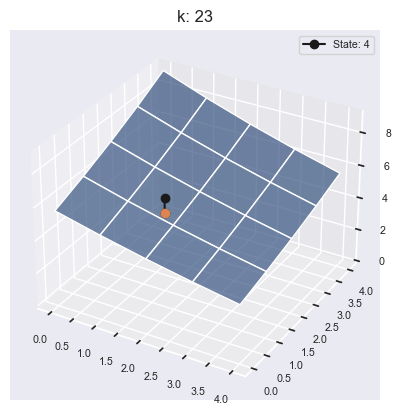

In [80]:
value_iteration(env = env, pi_next = env.agent.policy, theta = 0.1, V_0 = 0)